# Projet v3

In [2]:
import numpy as np
import pandas as pd
from scipy.io import arff

In [49]:
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probs = counts / len(labels)
    return -np.sum(probs * np.log2(probs))

def information_gain(data, split_column_name, target_column_name):
    original_entropy = entropy(data[target_column_name])
    
    weighted_entropy = 0
    total_rows = len(data)
    
    for value in data[split_column_name].unique():
        subset = data[data[split_column_name] == value]
        subset_entropy = entropy(subset[target_column_name])
        weighted_entropy += (len(subset) / total_rows) * subset_entropy
    
    information_gain = original_entropy - weighted_entropy
    return information_gain


def choose_best_column(data, label):
    best_gain = -1
    best_column = None
    
    for column in data.columns:
        if column != label:
            gain = information_gain(data, column, label)
#             print(column, gain)
            if gain > best_gain:
                best_gain = gain
                best_column = column
    
    return best_column

def create_single_rule(df, label):
    best_column = choose_best_column(df, label)

    best_value = df[best_column].value_counts().idxmax()
    
    filtered_df = df.loc[df[best_column] == best_value]
    predict_value = filtered_df[label].value_counts().idxmax()

    return dict(col_name=best_column, value=best_value, predict=predict_value)

def build_decision_tree(df, label, max_depth):
    if max_depth == 0:
        return None
    
    if len(df[label].unique()) == 1:
        return df[label].iloc[0]
    
    best_rule = create_single_rule(df, label)
    
    left_data = df[df[best_rule['col_name']] != best_rule['value']]
    right_data = df[df[best_rule['col_name']] == best_rule['value']]
    
    left_branch = build_decision_tree(left_data, label, max_depth - 1)
    right_branch = build_decision_tree(right_data, label, max_depth - 1)
    
    return {'rule': best_rule, 'left': left_branch, 'right': right_branch}

def predict(tree, sample):
    if isinstance(tree, dict):
        col_name = tree['rule']['col_name']
        value = tree['rule']['value']
        if sample[col_name] != value:
            return predict(tree['left'], sample)
        else:
            return predict(tree['right'], sample)
    else:
        return tree

def accuracy(tree, data, label):
    correct_predictions = 0
    total_samples = len(data)
    
    for _, sample in data.iterrows():
        prediction = predict(tree, sample)
        if prediction == sample[label]:
            correct_predictions += 1
    
    return correct_predictions / total_samples

# Fonction pour élaguer l'arbre en fonction de la précision de validation
def prune_tree(tree, validation_data, label):
    if not isinstance(tree, dict):
        return tree
    
    left_branch = tree['left']
    right_branch = tree['right']
    
    if not isinstance(left_branch, dict) and not isinstance(right_branch, dict):
        original_accuracy = accuracy(tree, validation_data, label)
        
        majority_class = validation_data[label].value_counts().idxmax()
        validation_data_size = len(validation_data)
        majority_class_accuracy = len(validation_data[validation_data[label] == majority_class]) / validation_data_size
        if majority_class_accuracy >= original_accuracy:
            return majority_class
    
    tree['left'] = prune_tree(left_branch, validation_data, label)
    tree['right'] = prune_tree(right_branch, validation_data, label)
    
    return tree

In [36]:
accuracy(tree, df, 'play')

0.8571428571428571

In [55]:
arff_file = arff.loadarff('./data/breast-cancer.arff')
df = pd.DataFrame(arff_file[0])

arff_file_test = arff.loadarff('./data/breast-cancer-test.arff')
df_test = pd.DataFrame(arff_file[0])

# Exemple d'utilisation
# Construire l'arbre de décision
tree = build_decision_tree(df, label='Class', max_depth=7)

# Élaguer l'arbre
pruned_tree = prune_tree(tree, df, label='Class')

# Évaluer la précision du modèle élagué
accuracy_pruned = accuracy(pruned_tree, df_test, label='Class')
accuracy_pruned

0.7931034482758621

In [30]:
df[df['outlook'] != b'sunny']

outlook temperature   humidity     windy    play
2   b'overcast'      b'hot'    b'high'  b'FALSE'  b'yes'
3      b'rainy'     b'mild'    b'high'  b'FALSE'  b'yes'
4      b'rainy'     b'cool'  b'normal'  b'FALSE'  b'yes'
5      b'rainy'     b'cool'  b'normal'   b'TRUE'   b'no'
6   b'overcast'     b'cool'  b'normal'   b'TRUE'  b'yes'
9      b'rainy'     b'mild'  b'normal'  b'FALSE'  b'yes'
11  b'overcast'     b'mild'    b'high'   b'TRUE'  b'yes'
12  b'overcast'      b'hot'  b'normal'  b'FALSE'  b'yes'
13     b'rainy'     b'mild'    b'high'   b'TRUE'   b'no'

In [52]:
import graphviz

def display_decision_tree(tree):
    dot = graphviz.Digraph(format='png')
    _add_nodes(tree, dot)
    return dot

def _add_nodes(tree, dot, parent=None, parent_condition=None):
    if isinstance(tree, dict):
        rule = tree['rule']
        condition = f"{rule['col_name']} == {rule['value'].decode('utf-8')}"
        if parent is not None and parent_condition is not None:
            dot.edge(parent, condition, label=parent_condition)
        _add_nodes(tree['left'], dot, parent=condition, parent_condition='True')
        _add_nodes(tree['right'], dot, parent=condition, parent_condition='False')
    else:
        dot.node(tree.decode('utf-8'), shape='box')
        if parent is not None and parent_condition is not None:
            dot.edge(parent, tree.decode('utf-8'), label=parent_condition)

display_decision_tree(tree)

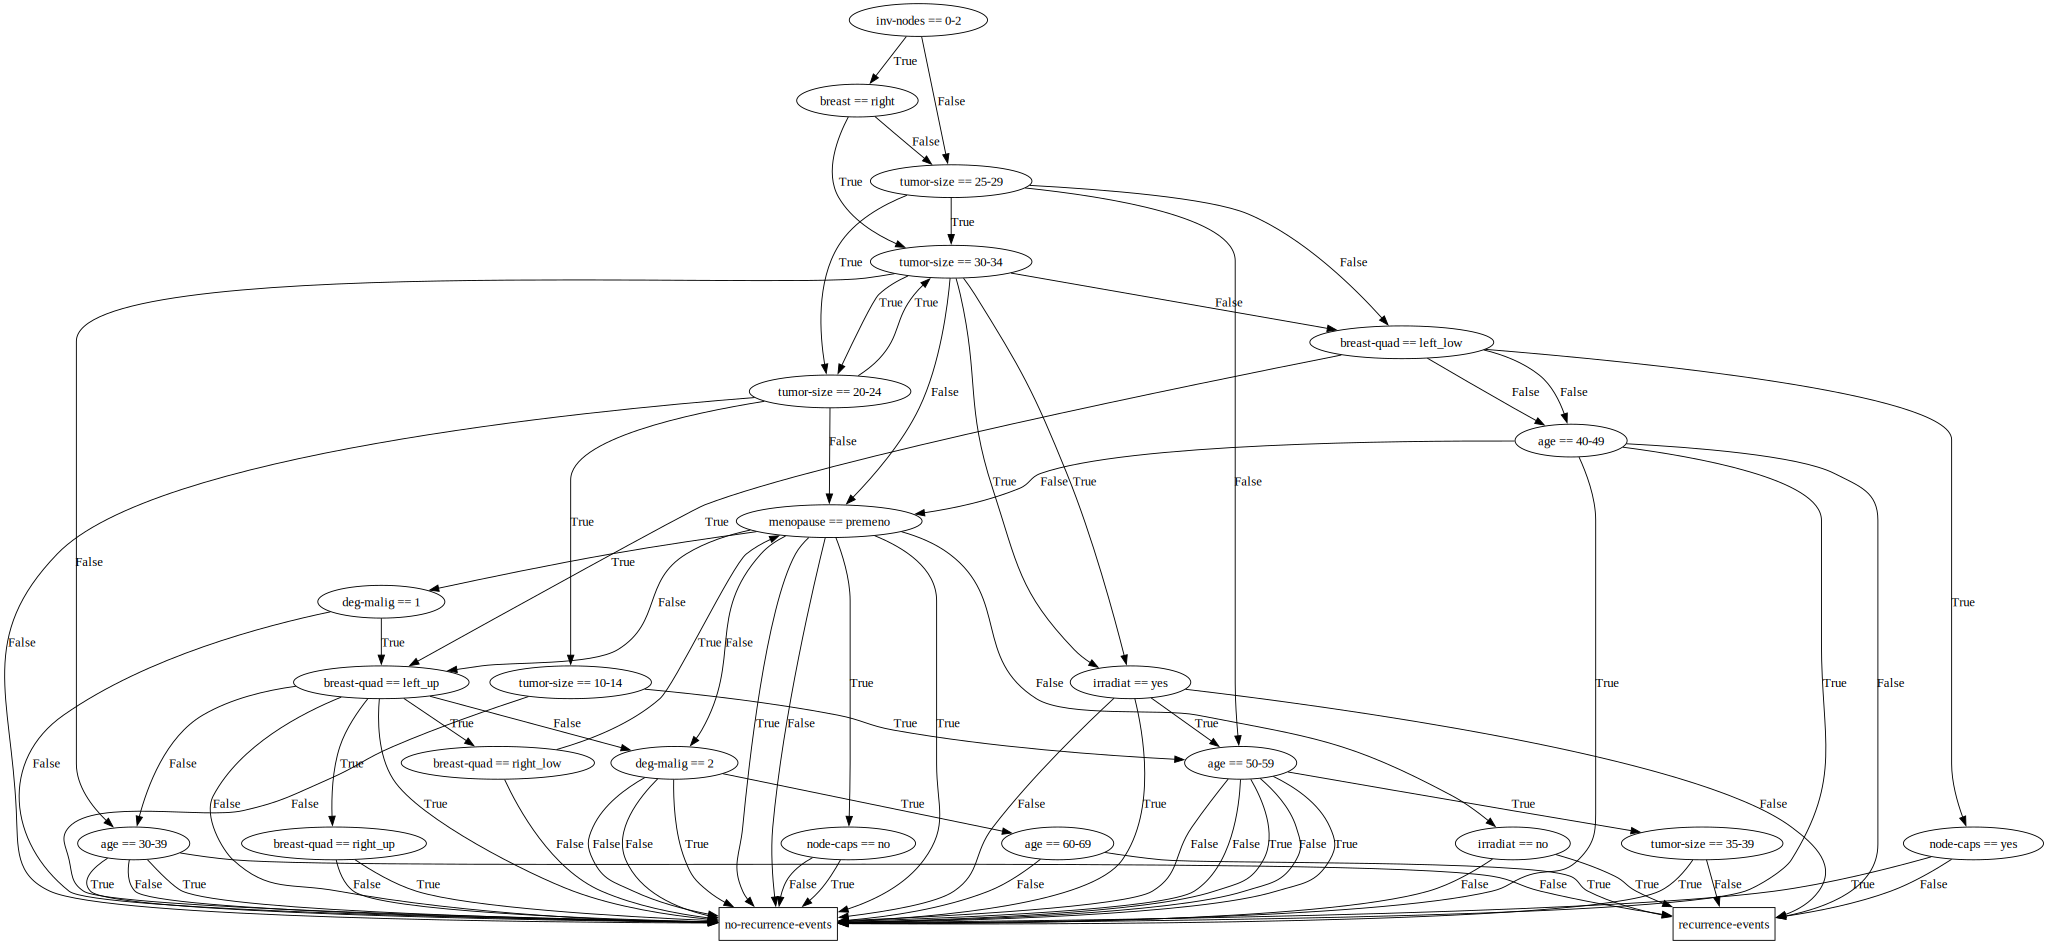

In [53]:
display_decision_tree(pruned_tree)

In [63]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_depth(train_data, validation_data, label, max_depth_range):
    accuracies = []
    pruned_accuracies = []
    
    for depth in max_depth_range:
        # Construire l'arbre de décision
        tree = build_decision_tree(train_data, label=label, max_depth=depth)
        # Calculer l'accuracy sur les données de validation
        accuracy_val = accuracy(tree, validation_data, label)
        accuracies.append(accuracy_val)
        
        # Construire et élaguer l'arbre de décision
        pruned_tree = prune_tree(tree, validation_data, label)
        # Calculer l'accuracy sur les données de validation
        pruned_accuracy_val = accuracy(pruned_tree, validation_data, label)
        pruned_accuracies.append(pruned_accuracy_val)
    
    # Tracer le graphique
    plt.figure(figsize=(8, 6))
    plt.plot(max_depth_range, accuracies, marker='o', linestyle='-', label='Decision Tree')
    plt.plot(max_depth_range, pruned_accuracies, marker='o', linestyle='-', color='red', label='Pruned Tree')
    plt.title('Évolution de l\'accuracy en fonction de la profondeur de l\'arbre')
    plt.xlabel('Profondeur de l\'arbre')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

# Définir la plage de profondeurs à tester
max_depth_range = range(1, 9)

# Tracer le graphique de l'évolution de l'accuracy
plot_accuracy_vs_depth(df, df_test, 'Class', max_depth_range)



In [64]:
df

age   menopause tumor-size inv-nodes node-caps deg-malig    breast  \
0    b'40-49'  b'premeno'   b'15-19'    b'0-2'    b'yes'      b'3'  b'right'   
1    b'50-59'     b'ge40'   b'15-19'    b'0-2'     b'no'      b'1'  b'right'   
2    b'50-59'     b'ge40'   b'35-39'    b'0-2'     b'no'      b'2'   b'left'   
3    b'40-49'  b'premeno'   b'35-39'    b'0-2'    b'yes'      b'3'  b'right'   
4    b'40-49'  b'premeno'   b'30-34'    b'3-5'    b'yes'      b'2'   b'left'   
..        ...         ...        ...       ...       ...       ...       ...   
227  b'40-49'     b'ge40'   b'30-34'    b'0-2'     b'no'      b'2'   b'left'   
228  b'30-39'  b'premeno'   b'25-29'    b'0-2'     b'no'      b'2'   b'left'   
229  b'40-49'  b'premeno'   b'20-24'    b'0-2'     b'no'      b'2'   b'left'   
230  b'30-39'  b'premeno'   b'20-24'    b'0-2'     b'no'      b'2'   b'left'   
231  b'40-49'  b'premeno'   b'10-14'    b'0-2'     b'no'      b'2'  b'right'   

      breast-quad irradiat                    Class  
0      b'left_up'    b'no'     b'recurrence-events'  
1      b'central'    b'no'  b'no-recurrence-events'  
2     b'left_low'    b'no'     b'recurrence-events'  
3     b'left_low'   b'yes'  b'no-recurrence-events'  
4     b'right_up'    b'no'     b'recurrence-events'  
..            ...      ...                      ...  
227    b'left_up'   b'yes'  b'no-recurrence-events'  
228   b'left_low'    b'no'  b'no-recurrence-events'  
229   b'left_low'    b'no'     b'recurrence-events'  
230  b'right_low'    b'no'  b'no-recurrence-events'  
231   b'left_low'    b'no'  b'no-recurrence-events'  

[232 rows x 10 columns]

In [65]:
df_test

age   menopause tumor-size inv-nodes node-caps deg-malig    breast  \
0    b'40-49'  b'premeno'   b'15-19'    b'0-2'    b'yes'      b'3'  b'right'   
1    b'50-59'     b'ge40'   b'15-19'    b'0-2'     b'no'      b'1'  b'right'   
2    b'50-59'     b'ge40'   b'35-39'    b'0-2'     b'no'      b'2'   b'left'   
3    b'40-49'  b'premeno'   b'35-39'    b'0-2'    b'yes'      b'3'  b'right'   
4    b'40-49'  b'premeno'   b'30-34'    b'3-5'    b'yes'      b'2'   b'left'   
..        ...         ...        ...       ...       ...       ...       ...   
227  b'40-49'     b'ge40'   b'30-34'    b'0-2'     b'no'      b'2'   b'left'   
228  b'30-39'  b'premeno'   b'25-29'    b'0-2'     b'no'      b'2'   b'left'   
229  b'40-49'  b'premeno'   b'20-24'    b'0-2'     b'no'      b'2'   b'left'   
230  b'30-39'  b'premeno'   b'20-24'    b'0-2'     b'no'      b'2'   b'left'   
231  b'40-49'  b'premeno'   b'10-14'    b'0-2'     b'no'      b'2'  b'right'   

      breast-quad irradiat                    Class  
0      b'left_up'    b'no'     b'recurrence-events'  
1      b'central'    b'no'  b'no-recurrence-events'  
2     b'left_low'    b'no'     b'recurrence-events'  
3     b'left_low'   b'yes'  b'no-recurrence-events'  
4     b'right_up'    b'no'     b'recurrence-events'  
..            ...      ...                      ...  
227    b'left_up'   b'yes'  b'no-recurrence-events'  
228   b'left_low'    b'no'  b'no-recurrence-events'  
229   b'left_low'    b'no'     b'recurrence-events'  
230  b'right_low'    b'no'  b'no-recurrence-events'  
231   b'left_low'    b'no'  b'no-recurrence-events'  

[232 rows x 10 columns]